In [18]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#LOF
from sklearn.neighbors import LocalOutlierFactor

from collections import Counter
from collections import defaultdict

import sys
sys.path.insert(1, '/Users/samuele/University/2.DM2/DataMining-2/')
sys.path.insert(1, '/Users/samuele/University/2.DM2/DataMining-2/fma_metadata/')
from utility_functions import report, summarize
import utils

### Schema

For detecting outliers we will not rely on just one estimator, but we will use a combination of them.<br>
In order to reduce the dimensionality of our data, we will use a PCA projection. <br>
After evaluating each anomaly estimator on our data, we will add a column to the original dataset indicating whether that row is an outlier or not.<br>
After all estimator have been tested on our data, we will take a majority voting.<br> For each row of data we will consider it an outlier if the majority of the estimator agreed on that estimate.

# Dataset Preparation

In [19]:
feat = utils.load('/Users/samuele/University/2.DM2/fma_metadata/features.csv')
gen_labels = pd.read_csv('/Users/samuele/University/2.DM2/fma_metadata/labels_genre_top.csv')

In [20]:
#remove duplicates and null values from features
print('Attributes before removing: ', feat.shape[0])
feat.dropna(inplace=True)
feat.isnull().sum()
print('Attributes after removing null values: ', feat.shape[0])
feat.drop_duplicates(keep=False, inplace=True)
print('Attributes after removing duplicates: ', feat.shape[0])

Attributes before removing:  106574
Attributes after removing null values:  106574
Attributes after removing duplicates:  102774


In [21]:
#add genres for each track
features = feat.merge(gen_labels, on='track_id')

#reset id
features = features.set_index('track_id')

#keep only rock and jazz tracks
features = features[features['genre_top'].isin(['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic','Pop','Classical','Jazz'])]

display(features.shape) 
display(features.head())

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


(33703, 519)

,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",genre_top
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,Hip-Hop
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,Hip-Hop
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,Hip-Hop
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623,Hip-Hop
135,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,0.609235,...,0.016731,0.020464,-0.038451,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899,Rock


In [22]:
# Data preprocessing
#le = preprocessing.LabelEncoder()
features['genre_top'] = preprocessing.LabelEncoder().fit_transform(features['genre_top'])
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Old-Time / Historic\n5: Jazz\n6: Pop\n7: Rock')
# Define the labels
labels = features[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels[['genre_top']]
features.head()

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Old-Time / Historic
5: Jazz
6: Pop
7: Rock


,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",genre_top
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,3
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,3
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,3
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623,3
135,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,0.609235,...,0.016731,0.020464,-0.038451,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899,7


## IQR score 

In [23]:
#function that detect outliers based on IQR 
def outlier_detector(var):
    ''' function that calculates Q1,Q3,IQR and return the number of outliers of a given variable'''
    Q1=features[var].quantile(0.25)
    Q3=features[var].quantile(0.75)
    IQR=Q3-Q1
    
    print('{}:'.format(var))
    print('Q1: {}\nQ3: {}\nIQR: {}'.format(Q1,Q3,IQR))
    
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    
    print('lower range: {}\nupper range: {}'.format(lower_whisker,upper_whisker))
    outliers = sum(features[var]<lower_whisker) + sum(features[var]>upper_whisker)
    print('{} has {} potential outliers'.format(var,outliers))
    


    #function that removes outliers
def outlier_remove(variable,u_whisker, l_whisker):
    df_clean.drop(index=features[features[variable]< l_whisker].index, inplace=True)
    df_clean.drop(index=features[features[variable]> u_whisker].index, inplace=True)

In [24]:
for col in features.iloc[:,:518].columns:
    outlier_detector(var=col)
    print('\n')

('chroma_cens', 'kurtosis', '01'):
Q1: -0.61470258236
Q3: 0.540446162225
IQR: 1.155148744585
lower range: -2.3474256992374998
upper range: 2.2731692791025
('chroma_cens', 'kurtosis', '01') has 1777 potential outliers


('chroma_cens', 'kurtosis', '02'):
Q1: -0.63729426265
Q3: 0.45817746222
IQR: 1.0954717248699999
lower range: -2.280501849955
upper range: 2.1013850495249997
('chroma_cens', 'kurtosis', '02') has 1682 potential outliers


('chroma_cens', 'kurtosis', '03'):
Q1: -0.60200917721
Q3: 0.557121664285
IQR: 1.1591308414950001
lower range: -2.3407054394525
upper range: 2.2958179265275
('chroma_cens', 'kurtosis', '03') has 1730 potential outliers


('chroma_cens', 'kurtosis', '04'):
Q1: -0.6238167882
Q3: 0.473373442885
IQR: 1.097190231085
lower range: -2.2696021348274997
upper range: 2.1191587895125
('chroma_cens', 'kurtosis', '04') has 1700 potential outliers


('chroma_cens', 'kurtosis', '05'):
Q1: -0.644788473845
Q3: 0.451686263085
IQR: 1.09647473693
lower range: -2.2895005792400

('chroma_cens', 'min', '03'):
Q1: 0.0
Q3: 0.0
IQR: 0.0
lower range: 0.0
upper range: 0.0
('chroma_cens', 'min', '03') has 7810 potential outliers


('chroma_cens', 'min', '04'):
Q1: 0.0
Q3: 0.00058484118199
IQR: 0.00058484118199
lower range: -0.0008772617729850001
upper range: 0.001462102954975
('chroma_cens', 'min', '04') has 7983 potential outliers


('chroma_cens', 'min', '05'):
Q1: 0.0
Q3: 5.573754606299999e-05
IQR: 5.573754606299999e-05
lower range: -8.36063190945e-05
upper range: 0.0001393438651575
('chroma_cens', 'min', '05') has 8119 potential outliers


('chroma_cens', 'min', '06'):
Q1: 0.0
Q3: 0.00010409805690999999
IQR: 0.00010409805690999999
lower range: -0.000156147085365
upper range: 0.000260245142275
('chroma_cens', 'min', '06') has 8196 potential outliers


('chroma_cens', 'min', '07'):
Q1: 0.0
Q3: 0.0
IQR: 0.0
lower range: 0.0
upper range: 0.0
('chroma_cens', 'min', '07') has 7962 potential outliers


('chroma_cens', 'min', '08'):
Q1: 0.0
Q3: 0.0
IQR: 0.0
lower range: 

('chroma_cqt', 'mean', '03') has 420 potential outliers


('chroma_cqt', 'mean', '04'):
Q1: 0.43176217377000004
Q3: 0.5848954319949999
IQR: 0.1531332582249999
lower range: 0.20206228643250018
upper range: 0.8145953193324997
('chroma_cqt', 'mean', '04') has 353 potential outliers


('chroma_cqt', 'mean', '05'):
Q1: 0.43579436838499996
Q3: 0.609153270725
IQR: 0.17335890234000007
lower range: 0.17575601487499987
upper range: 0.8691916242350002
('chroma_cqt', 'mean', '05') has 291 potential outliers


('chroma_cqt', 'mean', '06'):
Q1: 0.42698125541500004
Q3: 0.581121236085
IQR: 0.15413998066999995
lower range: 0.1957712844100001
upper range: 0.81233120709
('chroma_cqt', 'mean', '06') has 361 potential outliers


('chroma_cqt', 'mean', '07'):
Q1: 0.42452928424
Q3: 0.572111040355
IQR: 0.14758175611500002
lower range: 0.2031566500675
upper range: 0.7934836745275
('chroma_cqt', 'mean', '07') has 444 potential outliers


('chroma_cqt', 'mean', '08'):
Q1: 0.43322089314499995
Q3: 0.58979547024
IQ

('chroma_cqt', 'skew', '06') has 1089 potential outliers


('chroma_cqt', 'skew', '07'):
Q1: 0.020684229210000002
Q3: 0.5824759900600001
IQR: 0.56179176085
lower range: -0.822003412065
upper range: 1.4251636313350002
('chroma_cqt', 'skew', '07') has 1121 potential outliers


('chroma_cqt', 'skew', '08'):
Q1: -0.0064592862035999996
Q3: 0.60290694237
IQR: 0.6093662285736
lower range: -0.920508629064
upper range: 1.5169562852304
('chroma_cqt', 'skew', '08') has 1286 potential outliers


('chroma_cqt', 'skew', '09'):
Q1: -0.0077168410643999995
Q3: 0.5248712599300001
IQR: 0.5325881009944
lower range: -0.806598992556
upper range: 1.3237534114216
('chroma_cqt', 'skew', '09') has 1239 potential outliers


('chroma_cqt', 'skew', '10'):
Q1: 0.020026166923
Q3: 0.64240053296
IQR: 0.622374366037
lower range: -0.9135353821325001
upper range: 1.5759620820155
('chroma_cqt', 'skew', '10') has 1163 potential outliers


('chroma_cqt', 'skew', '11'):
Q1: 0.08287036418900001
Q3: 0.62895831466
IQR: 0.546087

('chroma_stft', 'mean', '10') has 351 potential outliers


('chroma_stft', 'mean', '11'):
Q1: 0.382342472675
Q3: 0.52577510476
IQR: 0.143432632085
lower range: 0.16719352454749997
upper range: 0.7409240528875001
('chroma_stft', 'mean', '11') has 322 potential outliers


('chroma_stft', 'mean', '12'):
Q1: 0.39475426078
Q3: 0.5436885952950001
IQR: 0.14893433451500016
lower range: 0.17135275900749974
upper range: 0.7670900970675003
('chroma_stft', 'mean', '12') has 358 potential outliers


('chroma_stft', 'median', '01'):
Q1: 0.32063981891000004
Q3: 0.518799424175
IQR: 0.19815960526499998
lower range: 0.023400411012500066
upper range: 0.8160388320725
('chroma_stft', 'median', '01') has 575 potential outliers


('chroma_stft', 'median', '02'):
Q1: 0.322884008285
Q3: 0.514591813085
IQR: 0.1917078048
lower range: 0.03532230108500006
upper range: 0.802153520285
('chroma_stft', 'median', '02') has 442 potential outliers


('chroma_stft', 'median', '03'):
Q1: 0.32820893823999997
Q3: 0.536252021

('chroma_stft', 'std', '02') has 624 potential outliers


('chroma_stft', 'std', '03'):
Q1: 0.255592733625
Q3: 0.30554769933
IQR: 0.049954965704999965
lower range: 0.18066028506750006
upper range: 0.38048014788749995
('chroma_stft', 'std', '03') has 547 potential outliers


('chroma_stft', 'std', '04'):
Q1: 0.2443202585
Q3: 0.291913330555
IQR: 0.04759307205500002
lower range: 0.17293065041749997
upper range: 0.3633029386375001
('chroma_stft', 'std', '04') has 633 potential outliers


('chroma_stft', 'std', '05'):
Q1: 0.25813668966000003
Q3: 0.30676153302000003
IQR: 0.04862484336
lower range: 0.18519942462000002
upper range: 0.37969879806000006
('chroma_stft', 'std', '05') has 606 potential outliers


('chroma_stft', 'std', '06'):
Q1: 0.251797839995
Q3: 0.30025573075
IQR: 0.04845789075500001
lower range: 0.17911100386249998
upper range: 0.37294256688250005
('chroma_stft', 'std', '06') has 621 potential outliers


('chroma_stft', 'std', '07'):
Q1: 0.24354151636500002
Q3: 0.29160115123
IQ

('mfcc', 'max', '20') has 950 potential outliers


('mfcc', 'mean', '01'):
Q1: -236.114845275
Q3: -120.55220413
IQR: 115.56264114499999
lower range: -409.45880699249994
upper range: 52.79175758749997
('mfcc', 'mean', '01') has 672 potential outliers


('mfcc', 'mean', '02'):
Q1: 126.046218875
Q3: 165.46560669000002
IQR: 39.41938781500002
lower range: 66.91713715249996
upper range: 224.59468841250003
('mfcc', 'mean', '02') has 452 potential outliers


('mfcc', 'mean', '03'):
Q1: -39.195356369
Q3: 0.13505867869
IQR: 39.33041504769
lower range: -98.19097894053502
upper range: 59.13068125022501
('mfcc', 'mean', '03') has 337 potential outliers


('mfcc', 'mean', '04'):
Q1: 22.473734856
Q3: 43.25629806549999
IQR: 20.78256320949999
lower range: -8.700109958249985
upper range: 74.43014287974998
('mfcc', 'mean', '04') has 1334 potential outliers


('mfcc', 'mean', '05'):
Q1: -6.552672386199999
Q3: 9.0582857132
IQR: 15.6109580994
lower range: -29.9691095353
upper range: 32.4747228623
('mfcc', '

('mfcc', 'min', '20') has 692 potential outliers


('mfcc', 'skew', '01'):
Q1: -2.1746524572499997
Q3: -0.641328275205
IQR: 1.5333241820449997
lower range: -4.4746387303174995
upper range: 1.6586579978624993
('mfcc', 'skew', '01') has 669 potential outliers


('mfcc', 'skew', '02'):
Q1: -1.5262093544000002
Q3: -0.43800358473999995
IQR: 1.0882057696600003
lower range: -3.1585180088900007
upper range: 1.1943050697500006
('mfcc', 'skew', '02') has 1080 potential outliers


('mfcc', 'skew', '03'):
Q1: -0.0562480278315
Q3: 0.8734990358350001
IQR: 0.9297470636665001
lower range: -1.4508686233312502
upper range: 2.2681196313347503
('mfcc', 'skew', '03') has 1054 potential outliers


('mfcc', 'skew', '04'):
Q1: -0.6321011185650001
Q3: 0.1360392496
IQR: 0.7681403681650001
lower range: -1.7843116708125002
upper range: 1.2882498018475002
('mfcc', 'skew', '04') has 883 potential outliers


('mfcc', 'skew', '05'):
Q1: -0.19292269647
Q3: 0.395262777805
IQR: 0.588185474275
lower range: -1.07520090788

('spectral_centroid', 'min', '01') has 709 potential outliers


('spectral_centroid', 'skew', '01'):
Q1: 0.85004463792
Q3: 2.80966114995
IQR: 1.9596165120300002
lower range: -2.0893801301250003
upper range: 5.749085917995
('spectral_centroid', 'skew', '01') has 2407 potential outliers


('spectral_centroid', 'std', '01'):
Q1: 377.74954223500004
Q3: 740.16714478
IQR: 362.4176025449999
lower range: -165.87686158249983
upper range: 1283.7935485975
('spectral_centroid', 'std', '01') has 690 potential outliers


('spectral_contrast', 'kurtosis', '01'):
Q1: 1.2723095417499999
Q3: 2.6036463976000004
IQR: 1.3313368558500005
lower range: -0.7246957420250009
upper range: 4.600651681375001
('spectral_contrast', 'kurtosis', '01') has 402 potential outliers


('spectral_contrast', 'kurtosis', '02'):
Q1: 0.31802546978
Q3: 0.977801561355
IQR: 0.659776091575
lower range: -0.6716386675824999
upper range: 1.9674656987174999
('spectral_contrast', 'kurtosis', '02') has 1327 potential outliers


('spectral

('spectral_contrast', 'skew', '03') has 1065 potential outliers


('spectral_contrast', 'skew', '04'):
Q1: 0.341398254035
Q3: 0.75761896372
IQR: 0.416220709685
lower range: -0.28293281049249996
upper range: 1.3819500282475001
('spectral_contrast', 'skew', '04') has 1928 potential outliers


('spectral_contrast', 'skew', '05'):
Q1: 0.328986242415
Q3: 0.86928141117
IQR: 0.5402951687549999
lower range: -0.4814565107174999
upper range: 1.6797241643024998
('spectral_contrast', 'skew', '05') has 1632 potential outliers


('spectral_contrast', 'skew', '06'):
Q1: 0.3266004622
Q3: 1.0913709402
IQR: 0.764770478
lower range: -0.8205552547999999
upper range: 2.2385266572
('spectral_contrast', 'skew', '06') has 1389 potential outliers


('spectral_contrast', 'skew', '07'):
Q1: -1.1640971303
Q3: 0.017694567330500004
IQR: 1.1817916976305
lower range: -2.9367846767457504
upper range: 1.7903821137762501
('spectral_contrast', 'skew', '07') has 1402 potential outliers


('spectral_contrast', 'std', '01')

('tonnetz', 'skew', '02') has 2876 potential outliers


('tonnetz', 'skew', '03'):
Q1: -0.28003078699
Q3: 0.32847642898499996
IQR: 0.608507215975
lower range: -1.1927916109525
upper range: 1.2412372529475
('tonnetz', 'skew', '03') has 1210 potential outliers


('tonnetz', 'skew', '04'):
Q1: -0.321810141205
Q3: 0.29090794920499996
IQR: 0.61271809041
lower range: -1.24088727682
upper range: 1.20998508482
('tonnetz', 'skew', '04') has 1185 potential outliers


('tonnetz', 'skew', '05'):
Q1: -0.17435751855499998
Q3: 0.22713372111000002
IQR: 0.401491239665
lower range: -0.7765943780525
upper range: 0.8293705806075
('tonnetz', 'skew', '05') has 1567 potential outliers


('tonnetz', 'skew', '06'):
Q1: -0.30450403690500005
Q3: 0.11023014411499998
IQR: 0.41473418102000004
lower range: -0.9266053084350001
upper range: 0.732331415645
('tonnetz', 'skew', '06') has 1521 potential outliers


('tonnetz', 'std', '01'):
Q1: 0.024206998758000003
Q3: 0.032886974513500006
IQR: 0.008679975755500002
lower r

## PCA for dimensionality reduction

In [25]:
genres = features['genre_top']
features.drop('genre_top', axis=1, inplace=True)
features.head()

,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(tonnetz, std, 04)","(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)"
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.058766,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623
135,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,0.609235,...,0.104279,0.016731,0.020464,-0.038451,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899


In [26]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [27]:
pca = PCA(2,random_state=42)
pca.fit(scaled_features)
df_pca = pca.transform(scaled_features)
df_pca = pd.DataFrame(df_pca, columns= ['pca1', 'pca2'])
df_pca

,pca1,pca2
0,1.315067,-2.506406
1,2.736502,-5.244442
2,-0.302637,-2.983402
3,0.026639,-6.749356
4,-0.269300,1.470947
...,...,...
33698,1.071013,0.041992
33699,3.443990,4.973695
33700,1.875343,-1.418010
33701,4.651963,-0.285579


Text(0.5, 1.0, 'Data distribution in 2D')

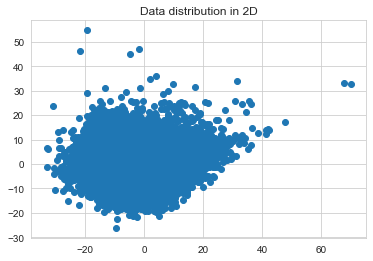

In [28]:
sns.set_style(style="whitegrid")
sns.set_color_codes()
plt.figure(figsize=(6,4))
plt.scatter(df_pca['pca1'],df_pca['pca2'])
plt.title('Data distribution in 2D')

## DBSCAN 

In [29]:
from sklearn.cluster import DBSCAN

outlier_detection = DBSCAN(eps= 1.1, metric='euclidean', min_samples=5, n_jobs=-1)

clusters= outlier_detection.fit_predict(df_pca)

In [30]:
# add column with outliers label
df_pca['outlier_DBSCAN'] = clusters
df_pca['outlier_DBSCAN'] = df_pca['outlier_DBSCAN'].apply(lambda x: 'outlier' if x==-1 else 'inlier')

Text(0.5, 1.0, 'Anomaly Score - DBSCAN')

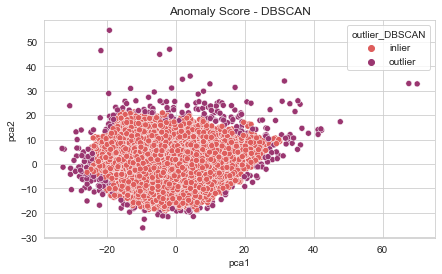

In [31]:
from matplotlib import cm
sns.set_style(style="whitegrid")
sns.set_color_codes()

plt.figure(figsize=(7,4))

cmap= cm.get_cmap('Set1')
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=df_pca['outlier_DBSCAN'], palette='flare')
plt.title('Anomaly Score - DBSCAN')

In [38]:
df_pca['track_id'] = features.index
df_pca = df_pca.set_index('track_id')
display(df_pca[df_pca['outlier_DBSCAN'] =='outlier']['outlier_DBSCAN'].value_counts()) 
display(df_pca.head())

outlier    303
Name: outlier_DBSCAN, dtype: int64

,pca1,pca2,outlier_DBSCAN
track_id,,,
2,1.315067,-2.506406,inlier
3,2.736502,-5.244442,inlier
5,-0.302637,-2.983402,inlier
134,0.026639,-6.749356,inlier
135,-0.269300,1.470947,inlier


In [41]:
features['outlier_dbscan_pca'] = df_pca['outlier_DBSCAN']
df_pca.drop(columns=['outlier_DBSCAN'], inplace=True)
features

,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",outlier_dbscan_pca
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,inlier
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,inlier
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,inlier
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623,inlier
135,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,0.609235,...,0.016731,0.020464,-0.038451,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899,inlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155315,-0.319850,0.653044,1.300360,-0.606061,-1.109302,-1.006683,0.059643,0.472580,-0.856436,-0.524676,...,0.016631,0.014705,6.947788,0.188477,0.037708,0.035156,0.002930,1.764233,0.018679,inlier
155316,-0.490129,0.463834,2.321970,-0.084352,1.662914,2.115189,-0.237794,5.695442,0.830353,1.951819,...,0.022547,0.019816,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385,inlier
155317,-0.461559,-0.229601,-0.496632,-0.422033,0.130612,-0.263825,-0.628103,-0.082687,-0.229483,-0.492753,...,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059,inlier


## LOF

In [135]:
from sklearn.neighbors import LocalOutlierFactor

In [142]:
clf = LocalOutlierFactor(n_neighbors=50, contamination=0.05)
outliers = clf.fit_predict(scaled_features) #use scaled_features for fully dimensional dataset

In [143]:
features['outlier_LOF'] = outliers
features['outlier_LOF'] = features['outlier_LOF'].apply(lambda x: 'inlier' if x==1 else 'outlier')

In [144]:
features[['outlier_LOF']].value_counts()

outlier_LOF
inlier         32017
outlier         1686
dtype: int64

In [145]:
clf.negative_outlier_factor_

array([-1.20233215, -1.12465941, -1.14857965, ..., -1.16748682,
       -1.05047965, -1.08494796])

In [146]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 1686, 32017]))

In [147]:
# maximum outlier score
np.max(clf.negative_outlier_factor_[np.where(outliers==-1)])

-1.4795074609292578

In [148]:
# minimum outlier score
np.min(clf.negative_outlier_factor_[np.where(outliers==-1)])

-7.39044036735692

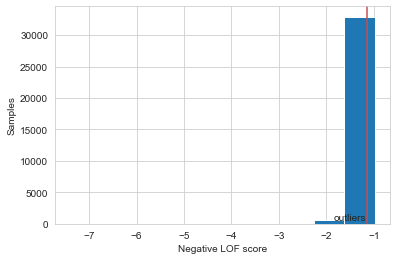

In [149]:
plt.figure(figsize=(6,4))
plt.hist(clf.negative_outlier_factor_, bins=10)
plt.axvline(-1.15, c='r')
plt.text(-1.85, 600, 'outliers')
plt.ylabel('Samples')
plt.xlabel('Negative LOF score')
plt.show()

Text(0.5, 1.0, 'Anomaly Score - LOF')

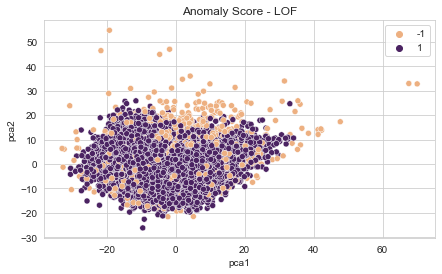

In [150]:
sns.set_style(style="whitegrid")
sns.set_color_codes()

plt.figure(figsize=(7,4))

cmap= cm.get_cmap('Set1')
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=outliers, palette='flare')
plt.title('Anomaly Score - LOF')

## KNN

In [ ]:
from pyod.models.knn import KNN
help(KNN)

In [126]:
clf = KNN(contamination = 0.05, n_neighbors=50)
clf.fit(scaled_features)

KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=50, p=2,
  radius=1.0)

In [136]:
clf.decision_scores_

array([19.59074959, 17.67352591, 17.95952337, ..., 18.40592844,
       15.29861815, 15.85780425])

In [137]:
anomlay_score = clf.decision_function(scaled_features)

In [138]:
outliers = clf.predict(scaled_features)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([32024,  1679]))

<AxesSubplot:xlabel='pca1', ylabel='pca2'>

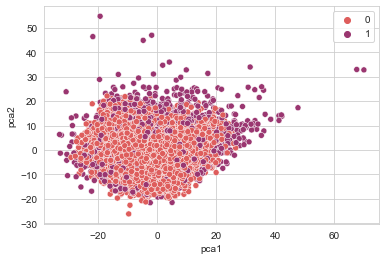

In [139]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=outliers, palette='flare')

In [140]:
features['outlier_KNN'] = outliers 
features['outlier_KNN'] = features['outlier_KNN'].apply(lambda x: 'inlier' if x==0 else 'outlier')

In [141]:
features['outlier_KNN'].value_counts()

inlier     32024
outlier     1679
Name: outlier_KNN, dtype: int64

## ABOD

In [91]:
from pyod.models.abod import ABOD

In [93]:
help(ABOD)

Help on class ABOD in module pyod.models.abod:

class ABOD(pyod.models.base.BaseDetector)
 |  ABOD(contamination=0.1, n_neighbors=5, method='fast')
 |  
 |  ABOD class for Angle-base Outlier Detection.
 |  For an observation, the variance of its weighted cosine scores to all
 |  neighbors could be viewed as the outlying score.
 |  See :cite:`kriegel2008angle` for details.
 |  
 |  Two version of ABOD are supported:
 |  
 |  - Fast ABOD: use k nearest neighbors to approximate.
 |  - Original ABOD: consider all training points with high time complexity at
 |    O(n^3).
 |  
 |  Parameters
 |  ----------
 |  contamination : float in (0., 0.5), optional (default=0.1)
 |      The amount of contamination of the data set, i.e.
 |      the proportion of outliers in the data set. Used when fitting to
 |      define the threshold on the decision function.
 |  
 |  n_neighbors : int, optional (default=10)
 |      Number of neighbors to use by default for k neighbors queries.
 |  
 |  method: str,

In [94]:
clf = ABOD(contamination = 0.05, n_neighbors=50)
clf.fit(scaled_features)

ABOD(contamination=0.05, method='fast', n_neighbors=50)

In [95]:
clf.decision_scores_

array([-8.83406342e-08, -1.00311079e-07, -1.22001945e-07, ...,
       -1.30635343e-07, -2.50137326e-07, -1.31727861e-07])

In [96]:
outliers = clf.predict(scaled_features)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([32026,  1677]))

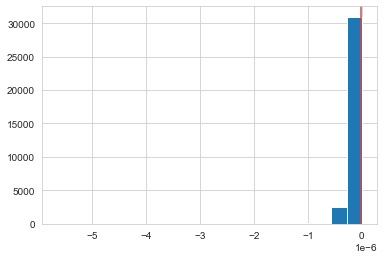

In [97]:
plt.figure(figsize=(6,4))
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='r')
plt.show()

<AxesSubplot:xlabel='pca1', ylabel='pca2'>

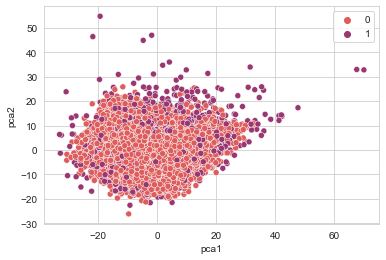

In [98]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=outliers, palette='flare')

In [99]:
# save outlier scores to df
features['outlier_ABOD'] = outliers 
features['outlier_ABOD'] = features['outlier_ABOD'].apply(lambda x: 'inlier' if x==0 else 'outlier')

In [100]:
features['outlier_ABOD'].value_counts()

inlier     32026
outlier     1677
Name: outlier_ABOD, dtype: int64

## Isolation Forest & Extended Isolation Forest 

In [101]:
import eif as iso
sns.set_style(style="whitegrid")
sns.set_color_codes()

In [102]:
# transform data in an np.ndarray 
X = np.array(df_pca)
X_fd= np.array(scaled_features)  #no dim reduction

### Train forest 
**ntree** = number of trees to be used in fitting the forest<br>
**sample_size** = number of rows to be sub-sampled in creating each tree. This must be less than the number of observations in the dataset

In [103]:
# PCA REDUCTION FORESTS
F0  = iso.iForest(X, ntrees=600, sample_size=100, ExtensionLevel=0) # ExtensionLevel=0 is the same as regular Isolation Forest
F1  = iso.iForest(X, ntrees=600, sample_size=100, ExtensionLevel=1)

# FULL DIMENSIONALITY FORESTS
F0_fd =iso.iForest(X_fd, ntrees=600, sample_size=100, ExtensionLevel=0)
F1_fd  = iso.iForest(X_fd, ntrees=600, sample_size=100, ExtensionLevel=1)

In [104]:
xxx = np.array([[0,0.]])
SL0 = F0.compute_paths_single_tree(xxx, 0)

### Score data

In [105]:
# Score the training data itself to see the distribution of the anomaly scores each point receives. 

# PCA reduction
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)

# full dimensionality
S0_fd = F0_fd.compute_paths(X_in=X_fd)
S1_fd = F1_fd.compute_paths(X_in=X_fd)

In [106]:
# PCA reduction
features['outlier_IF-PCA'] = S0
features['outlier_IF-PCA'] = features['outlier_IF-PCA'].apply(lambda x: 'inlier' if x<=0.6 else 'outlier')
features['outlier_EIF-PCA'] = S1
features['outlier_EIF-PCA'] = features['outlier_EIF-PCA'].apply(lambda x: 'inlier' if x<=0.6 else 'outlier')

In [108]:
features['outlier_IF'] = S0_fd
features['outlier_IF'] = features['outlier_IF'].apply(lambda x: 'inlier' if x<=0.6 else 'outlier')
features['outlier_EIF'] = S1_fd
features['outlier_EIF'] = features['outlier_EIF'].apply(lambda x: 'inlier' if x<=0.6 else 'outlier')

In [109]:
# pca EIF
features['outlier_EIF-PCA'].value_counts()

inlier     32211
outlier     1492
Name: outlier_EIF-PCA, dtype: int64

In [110]:
# pca IF
features['outlier_IF-PCA'].value_counts()

inlier     31714
outlier     1989
Name: outlier_IF-PCA, dtype: int64

In [111]:
# full dim EIF
features['outlier_EIF'].value_counts()

inlier     33688
outlier       15
Name: outlier_EIF, dtype: int64

In [112]:
# full dim IF
features['outlier_IF'].value_counts()

inlier     33695
outlier        8
Name: outlier_IF, dtype: int64

### Plot anomaly score 

Text(0.5, 1.0, 'eif - Extended Isolation Tree (PCA)')

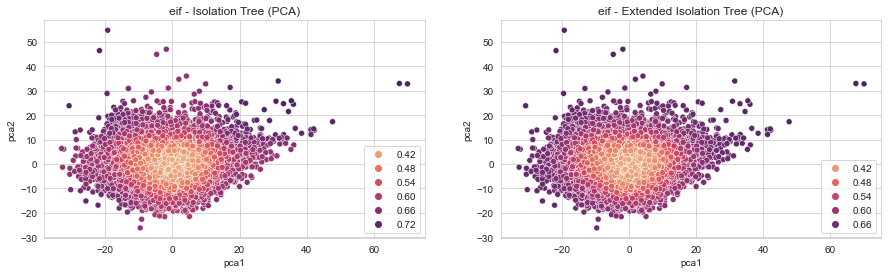

In [113]:
# ------- eif: Isolation Forest and Extended Isolation Forest - PCA projection ------------------------------#
f = plt.figure(figsize=(15,4))

ax1 = f.add_subplot(121)
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=S0,palette='flare')
plt.title('eif - Isolation Tree (PCA)')

ax2 = f.add_subplot(122)
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=S1,palette='flare')
plt.title('eif - Extended Isolation Tree (PCA)')

Text(0.5, 1.0, 'eif - Extended Isolation Tree (full-dim plotted in 2D)')

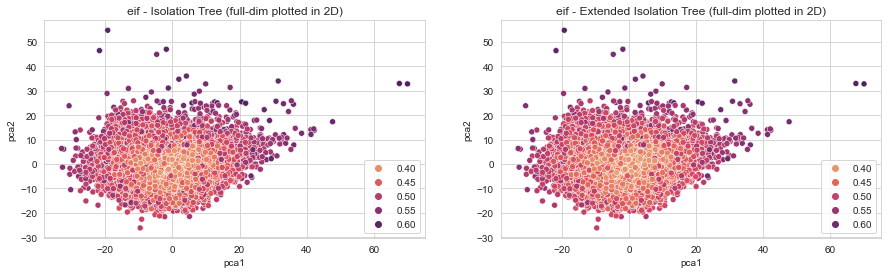

In [114]:
# ------- eif: Isolation Forest and Extended Isolation Forest - full dimensionality ------------------------------#
f = plt.figure(figsize=(15,4))

ax1 = f.add_subplot(121)
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=S0_fd,palette='flare')
plt.title('eif - Isolation Tree (full-dim plotted in 2D)')


ax2 = f.add_subplot(122)
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=S1_fd,palette='flare')
plt.title('eif - Extended Isolation Tree (full-dim plotted in 2D)')

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


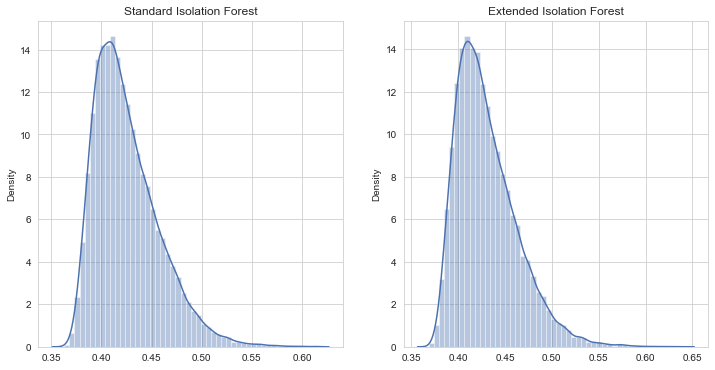

In [115]:
# Isolation forest full-dim - eif
f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(S0_fd, kde=True, color="b")
plt.title('Standard Isolation Forest')

# Extended Isolation forest full-dim - eif
plt.subplot(1,2,2)
sns.distplot(S1_fd, kde=True, color="b")
plt.title('Extended Isolation Forest')
plt.show()

In [116]:
xx, yy = np.meshgrid(np.linspace(-5., 6., 50), np.linspace(-5., 6, 50))

S0_ = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0_ = S0_.reshape(xx.shape)

S1_ = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1_ = S1_.reshape(xx.shape)

In [117]:
S0_.shape

(50, 50)

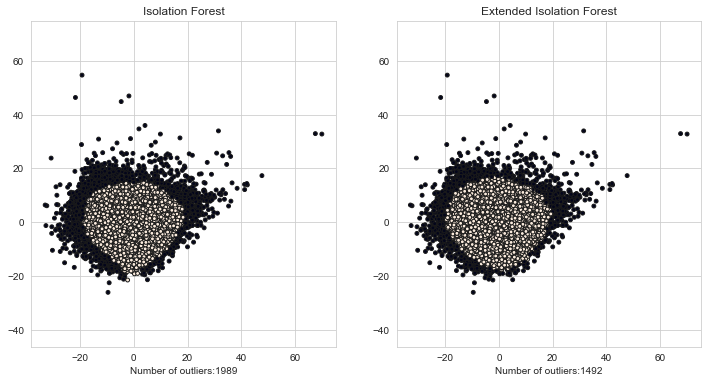

In [120]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0_),np.max(S0_),10)
CS = ax1.contourf(xx, yy, S0_, levels, cmap=plt.cm.YlOrRd)
plt.scatter(df_pca['pca1'],df_pca['pca2'],s=15,c=features['outlier_IF-PCA'].apply(lambda x: 0 if x=='inlier' else -1),edgecolors='k')
plt.axis("equal")
plt.title('Isolation Forest')
plt.xlabel(f"Number of outliers:{features['outlier_IF-PCA'].value_counts()[1]}")



ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1_),np.max(S0_),10)
CS = ax2.contourf(xx, yy, S1_, levels, cmap=plt.cm.YlOrRd)

plt.scatter(df_pca['pca1'],df_pca['pca2'],s=15,c=features['outlier_EIF-PCA'].apply(lambda x: 0 if x=='inlier' else -1),edgecolors='k')
plt.axis("equal")
plt.title('Extended Isolation Forest')
plt.xlabel(f"Number of outliers:{features['outlier_EIF-PCA'].value_counts()[1]}")

plt.show()

In [123]:
features.head()


,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(zcr, skew, 01)","(zcr, std, 01)",outlier_dbscan_pca,outlier_LOF,outlier_KNN,outlier_ABOD,outlier_IF-PCA,outlier_EIF-PCA,outlier_IF,outlier_EIF
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,2.089872,0.061448,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,1.716724,0.069330,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,2.193303,0.044861,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,1.806106,0.054623,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
135,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,0.609235,...,0.297873,0.024899,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier


In [152]:
# majority voting
mostCommonVote=[]
for row in features[['outlier_dbscan_pca', 'outlier_LOF', 'outlier_KNN','outlier_ABOD','outlier_IF-PCA','outlier_EIF-PCA', 'outlier_IF', 'outlier_EIF']].values:
    votes, values = np.unique(row, return_counts=True)
    if np.all(values<=1):
            mostCommonVote.append( row[0] )
    else:
        mostCommonVote.append( votes[np.argmax(values)] )

features['Winner'] = mostCommonVote

In [153]:
features[['Winner']].value_counts()

Winner 
inlier     33373
outlier      330
dtype: int64

In [154]:
features[features['Winner']=='outlier']

,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(zcr, std, 01)",outlier_dbscan_pca,outlier_LOF,outlier_KNN,outlier_ABOD,outlier_IF-PCA,outlier_EIF-PCA,outlier_IF,outlier_EIF,Winner
track_id,,,,,,,,,,,,,,,,,,,,,
889,-0.897146,1.160911,-0.160328,0.128445,-1.426012,0.754325,-0.158148,0.703347,-0.691765,11.914546,...,0.015390,inlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier
1300,16.989441,43.409588,41.355400,0.017483,164.880539,194.719330,73.180061,439.131195,188.034485,221.147018,...,0.015181,inlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier
1309,0.532405,34.664978,25.631742,1.226247,2.222338,3.776371,-0.381408,-0.386589,-1.159522,0.343070,...,0.035162,inlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier
1335,0.874210,24.505541,7.361331,0.284156,0.915207,3.754633,0.122404,0.243308,0.458094,20.302004,...,0.017787,inlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier
1337,-0.861590,-0.397602,-0.239038,-0.328654,-0.426372,-0.838415,-1.183366,-0.913822,-0.948904,1.419288,...,0.089616,inlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154303,-0.635349,-0.999377,-1.258559,-1.162947,-0.292654,0.100518,-1.737831,-1.642728,-1.383463,1.650860,...,0.132647,inlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier
154305,2.465099,-1.672543,-1.630980,-1.724004,2.791795,5.831522,-1.188136,-1.525297,-1.547286,0.691139,...,0.056396,inlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier
154919,-1.030529,-0.958544,4.057062,-1.713945,-1.571156,-1.505085,-1.076234,0.376693,-1.545035,-1.410502,...,0.090346,inlier,outlier,outlier,outlier,outlier,outlier,inlier,inlier,outlier


In [155]:
features[features['Winner']=='outlier'].index

Int64Index([   889,   1300,   1309,   1335,   1337,   1431,   1441,   1486,
              1544,   1755,
            ...
            152321, 152331, 153362, 154293, 154300, 154303, 154305, 154919,
            154924, 155144],
           dtype='int64', name='track_id', length=330)

### Plot the average outlier score

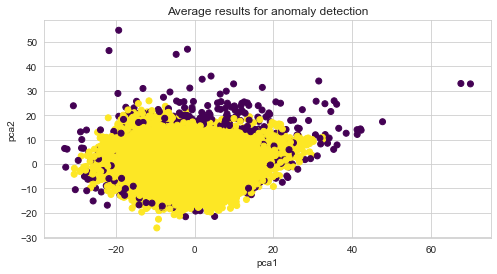

In [160]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

x = df_pca['pca1']
y = df_pca['pca2']
c = features['Winner'].apply(lambda x: -1 if x == 'outlier' else 1)

ax.set_xlabel("pca1")
ax.set_ylabel("pca2")

scatter = ax.scatter(x, y, c=c, cmap='viridis')
ax.set_title('Average results for anomaly detection')
plt.show()

### Remove outliers

In [173]:
df_without_outliers = features.drop(index=features[features['Winner']=='outlier'].index, axis=0)
df_without_outliers.head()

,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(zcr, std, 01)",outlier_dbscan_pca,outlier_LOF,outlier_KNN,outlier_ABOD,outlier_IF-PCA,outlier_EIF-PCA,outlier_IF,outlier_EIF,Winner
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.061448,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.069330,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.044861,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.054623,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
135,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,0.609235,...,0.024899,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier


In [174]:
# remove cols for outlier scores
df_without_outliers = df_without_outliers.drop(['outlier_dbscan_pca', 'outlier_LOF', 'outlier_KNN','outlier_ABOD','outlier_IF-PCA','outlier_EIF-PCA', 'outlier_IF', 'outlier_EIF', 'Winner'], axis=1)
df_without_outliers.head()

,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(tonnetz, std, 04)","(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)"
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.058766,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623
135,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,0.609235,...,0.104279,0.016731,0.020464,-0.038451,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899


In [177]:
# re-attach genre labels
labels = pd.read_csv('/Users/samuele/University/2.DM2/fma_metadata/labels_genre_top.csv')
labels = labels.set_index('track_id')
df_without_outliers = df_without_outliers.merge(labels, on='track_id')
df_without_outliers.head()

,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",genre_top
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,Hip-Hop
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,Hip-Hop
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,Hip-Hop
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623,Hip-Hop
135,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,0.609235,...,0.016731,0.020464,-0.038451,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899,Rock


In [178]:
df_without_outliers['genre_top'].value_counts()

Rock                   13955
Electronic              8748
Hip-Hop                 3447
Folk                    2741
Pop                     2180
Classical               1203
Jazz                     550
Old-Time / Historic      549
Name: genre_top, dtype: int64

In [179]:
#df_without_outliers.to_csv('/Users/samuele/anomaly_detection-librosa.csv')